In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


## Install packages

We need 1 external packages
- [Scienceplots](https://pypi.org/project/SciencePlots/) For better plotting styles

In [2]:
!pip install scienceplots

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sys
import seaborn as sns
import random
import imblearn as imb # For handling imbalanced datasets
import scienceplots
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
plt.style.use(["science", "notebook", "grid"])

print('Python: {}'.format(sys.version)[:14])
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Seaborn: {}'.format(sns.__version__))
print('Matplotlib: {}'.format(plt.matplotlib.__version__))
print(f"Tensorflow: {tf.__version__}")
print(f"Imbalanced-learn: {imb.__version__}")

pd.set_option("display.max_columns", 100)

# To plot the figures inline with the text
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Python: 3.10.1
Numpy: 1.23.5
Pandas: 1.5.3
Seaborn: 0.12.2
Matplotlib: 3.7.1
Tensorflow: 2.12.0
Imbalanced-learn: 0.10.1


In [4]:
# Set seed for reproducible results
SEED = 123
tf.random.set_seed(SEED)

In [5]:
# Import the dataset
train_data = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
test_data = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

# Print the first 5 rows of the dataframe.
train_data.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


#### See information regarding the dataset

Obviously, the `ID` column is the only column that is not a feature. The `ID` column is a unique identifier for each patient. The `Class` column is the target variable. We can safely drop the `Id` column without affecting anything.

In [6]:
train_data = train_data.drop(columns = ["Id"])

In [7]:
def get_information(dataframe: pd.DataFrame, see_cols: bool = True) -> None:
    """Prints the shape, columns, and missing values of a dataframe.
    Args:
        dataframe (pd.DataFrame): The dataframe to be analyzed
        see_cols(bool) : Whether to see the names of the columns or not. True by default
    Returns:
        None"""
    print("Number of rows: {}".format(dataframe.shape[0]))
    print("Number of columns: {}".format(dataframe.shape[1]))
    print("Missing values: {}".format(dataframe.isnull().sum().values.sum()))

    if see_cols:
        print("Features: {}".format(dataframe.columns.tolist()))
        
print("Information of training dataset:")
get_information(train_data, see_cols = True)
print("-"*100)
print("Information of testing dataset:")
get_information(test_data, see_cols = True)

Information of training dataset:
Number of rows: 617
Number of columns: 57
Missing values: 131
Features: ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class']
----------------------------------------------------------------------------------------------------
Information of testing dataset:
Number of rows: 5
Number of columns: 57
Missing values: 0
Features: ['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL

<Axes: title={'center': 'Dtypes of testing dataset'}>

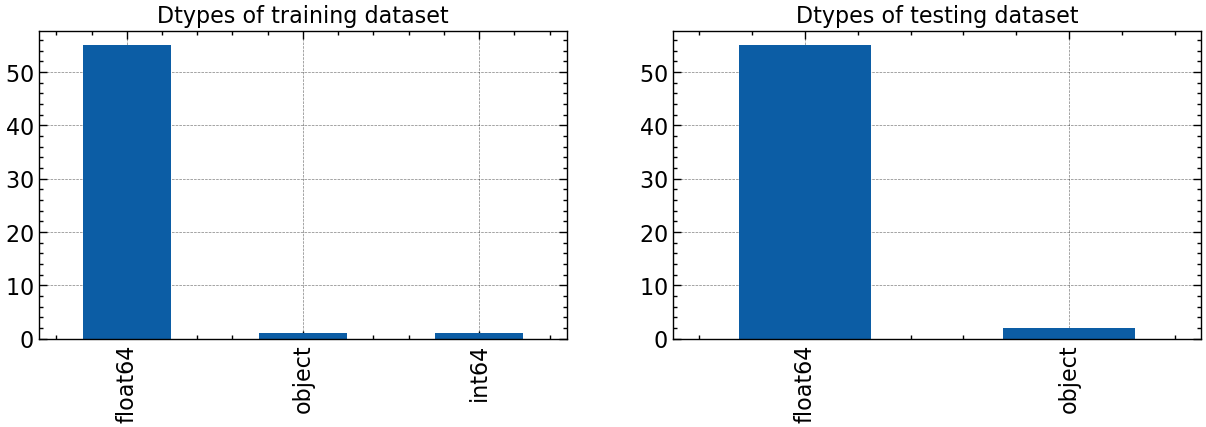

In [8]:
## See the dtypes of the dataframe more closely
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax1, ax2 = ax.ravel()
train_data.dtypes.value_counts().plot.bar(title = "Dtypes of training dataset", ax = ax1)
test_data.dtypes.value_counts().plot.bar(title = "Dtypes of testing dataset", ax = ax2)

**NOTE:** : `Object` dtypes need to be handled in the preprocessing phase. 

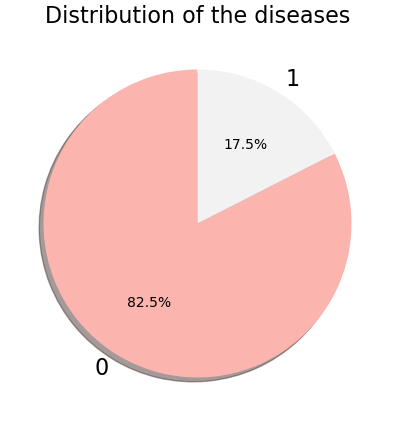

In [9]:
train_data["Class"].value_counts().plot(kind = "pie", figsize = (10, 5), cmap = 'Pastel1',
                                        title="Distribution of the diseases", ylabel = '',
                                        autopct='%1.1f%%', shadow=True, startangle=90);

# Data Imbalance
One concern with this dataset, is that the incidence in the target variable shows the dataset might be imbalanced. Target incidence shows if the dataset is balanced or imbalanced. It is defined as the number of cases of each individual target value in a dataset. This is important since the aim of the project is to predict the binary class of the sample. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:
* Class 0
* Class 1

## Synthetic Minority Over-sampling Technique (SMOTE)
SMOTE is a technique based on nearest neighbors judged by Euclidean Distance between data points in feature space. For this project I used Synthetic Minority Over-sampling Technique for Nominal and Continuous features (SMOTE-NC) from the imbalanced-learn library, which creates synthetic data for categorical as well as quantitative features in the data set. SMOTE-NC slightly changes the way a new sample is generated by performing something specific for the categorical features. In fact, the categories of a new generated sample are decided by picking the most frequent category of the nearest neighbors present during the generation.

**We will aply SMOTE after preprocessing the dataset.**

## Pipeline of the preprocessing of the data:

* Break the data into targets and features.

* Identify the numerical columns in the dataset and the categorical columns

**NOTE:** There may be missing values in both kinds of columns.

* Break the dataset into training and testing dataset.

* Design a preprocessor to `Impute` the data and then `scale` the data using `Normalization` and ***NOT*** `Standardization`.
$$
X_{normalized} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$
Normalization tends to work better with deep neural networks.

* Fit the preprocessor pipeline on the training data and transform the training and testing dataset with that pipeline.

* Create tensorflow tensors from the training and testing data.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, PowerTransformer, StandardScaler

In [11]:
# Break dataset into features and labels
X = train_data.drop(columns = ["Class"]) # Features
y = train_data["Class"] # Labels
X["BC_BZ"] = X['BC'] / X["BZ"]

## Mutual information¶
We will use mutual information to see which features are more important than others. Mutual information is a measure of the mutual dependence between two random variables. It is used to measure the amount of information obtained about one random variable through observing the other random variable. It is a non-negative value, and 0 means that the two random variables are independent. The higher the mutual information, the more dependent the two random variables are.

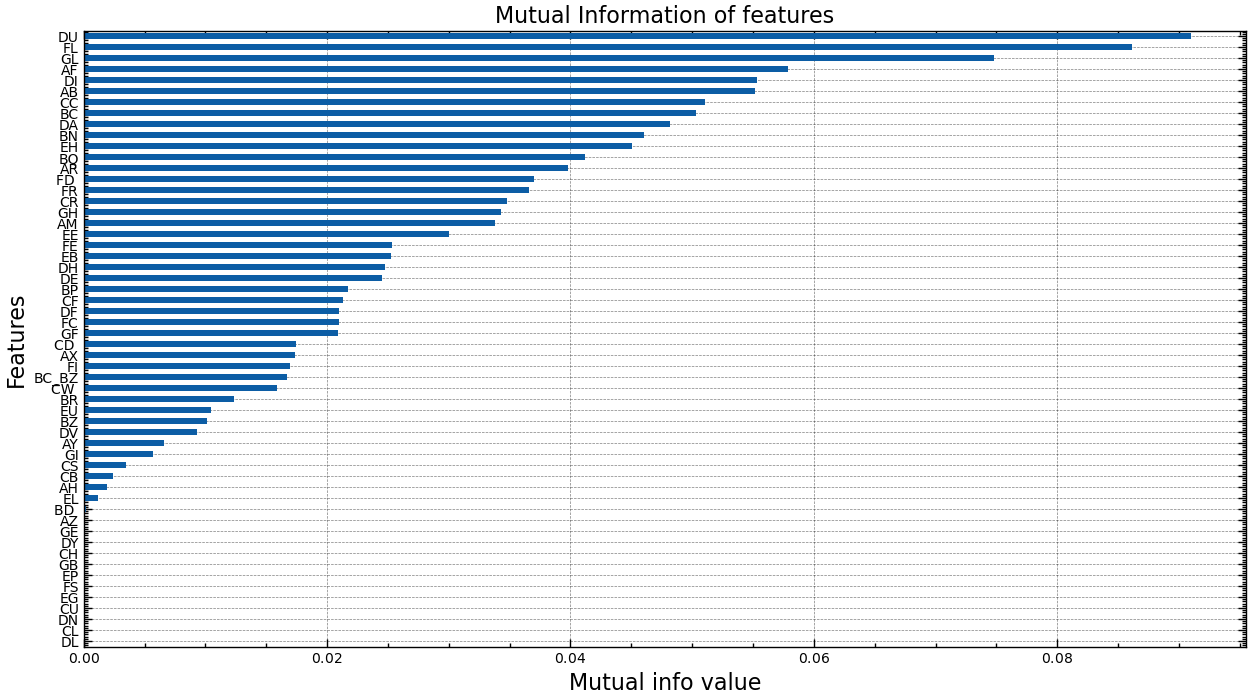

In [12]:
from sklearn.feature_selection import mutual_info_classif
def get_mi_score(X, y, discrete_features='auto'):
    mi_scores = mutual_info_classif(X.select_dtypes(include = ["float", "int"]), 
                                    y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X\
                                              .select_dtypes(include = ["float", "int"])\
                                                              .columns)
    mi_scores = mi_scores.sort_values(ascending=True)
    return mi_scores

mi_scores = get_mi_score(X.fillna(method = "bfill"), y)
mi_scores.plot(kind = "barh", figsize = (15, 8), fontsize = 10, title = "Mutual Information of features", 
              ylabel = "Features", xlabel = "Mutual info value")

# Take only the necessary columns
threshold_mi = (mi_scores.sum() / len(mi_scores))
columns_to_take = mi_scores[mi_scores > threshold_mi].index.tolist()

# Rewrite original dataset with necessary columns
X = X[columns_to_take]

In [13]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(exclude = ["object"]).columns
categorical_cols = X.select_dtypes(include = ["object"]).columns

print(f"Categorical columns = {categorical_cols}")
print(f"Numerical columns = {numerical_cols}")

# Split dataset into training nad testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = SEED)
print(f"shape of X_train = {X_train.shape}")
print(f"shape of X_test = {X_test.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"shape of y_test = {y_test.shape}")

Categorical columns = Index([], dtype='object')
Numerical columns = Index(['DE', 'DH', 'EB', 'FE', 'EE', 'AM', 'GH', 'CR', 'FR', 'FD ', 'AR', 'BQ',
       'EH', 'BN', 'DA', 'BC', 'CC', 'AB', 'DI', 'AF', 'GL', 'FL', 'DU'],
      dtype='object')
shape of X_train = (493, 23)
shape of X_test = (124, 23)
Shape of y_train = (493,)
shape of y_test = (124,)


In [14]:
# Design preprocessor for numerical and categorical columns
num_pipeline = Pipeline(steps = [("imputer", SimpleImputer(strategy="mean")), 
                                ("scaler", MinMaxScaler()),
#                                  ("standard_scaler", StandardScaler()),
#                                 ("pca", PCA()), 
#                                  ("power_transform", PowerTransformer(method = 'yeo-johnson', standardize = False)),
                                ("poly_features", PolynomialFeatures(degree = 2))])

cat_pipeline = Pipeline(steps = [
                        ("encoder", OneHotEncoder())])


preprocessor = ColumnTransformer([
    ("num_pipeline", num_pipeline, numerical_cols),
    ("cat_pipeline", cat_pipeline, categorical_cols)])

# Fit the training set with the preprocessor
preprocessor.fit(X_train)

# Transform the training and testing dataset with the fitted preprocessor
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

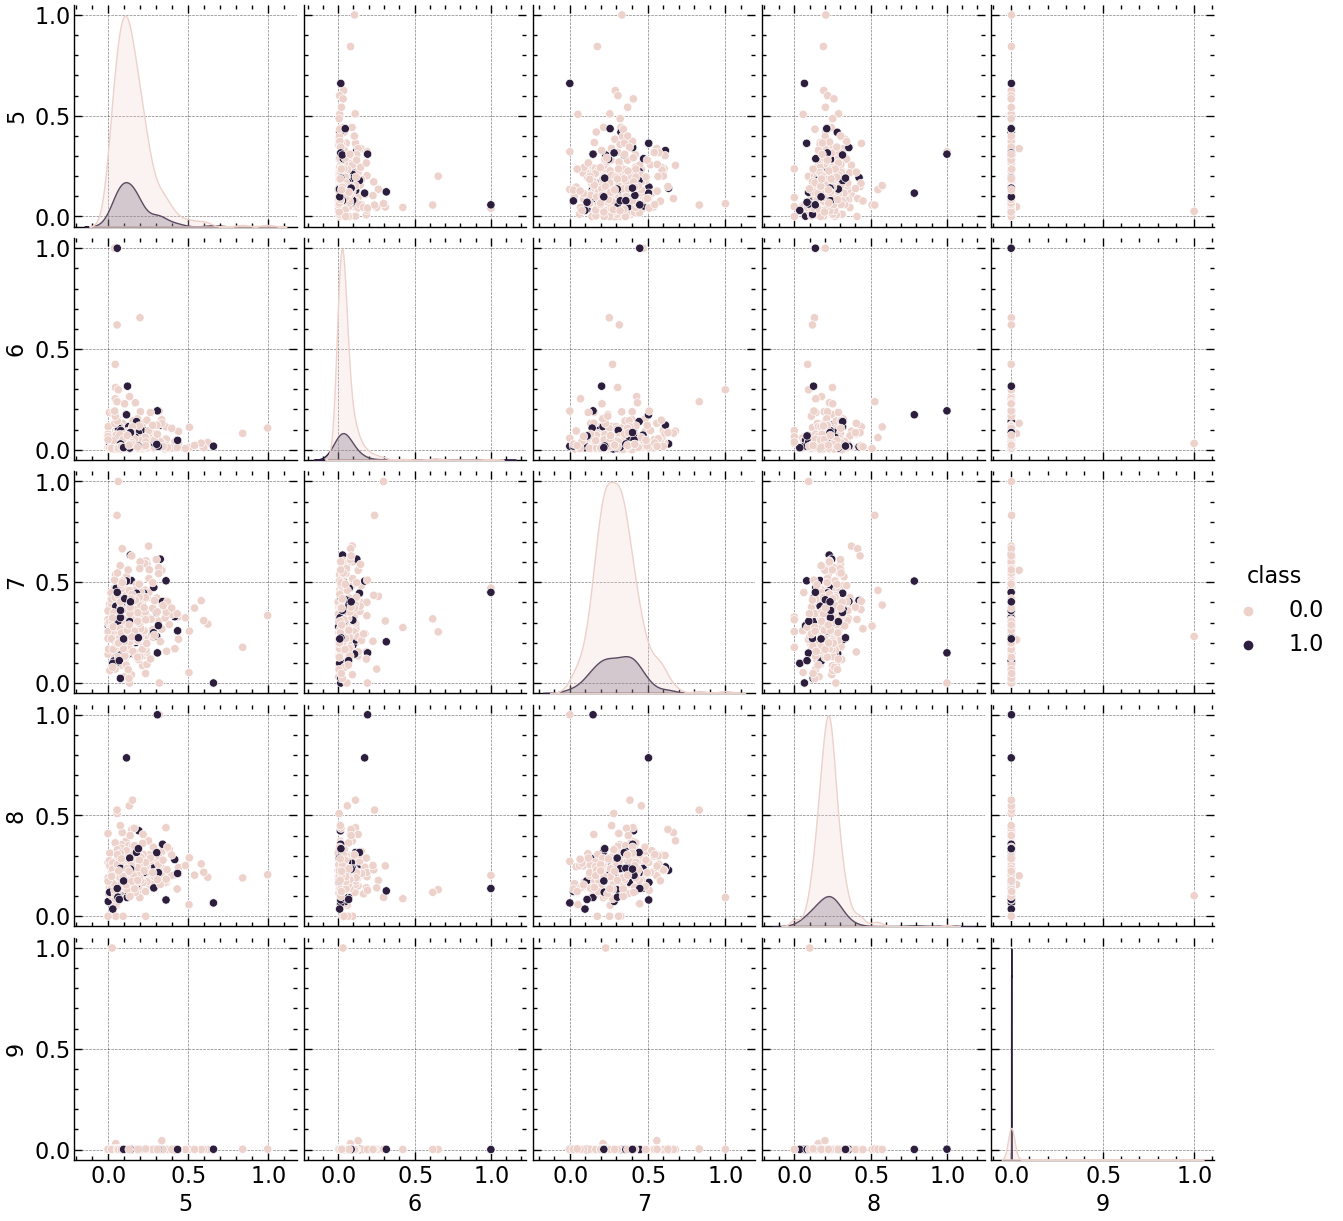

In [15]:
test_df = pd.DataFrame(X_train).copy()
test_df["class"] = y_train
sns.pairplot(test_df, x_vars = range(5, 10), y_vars = range(5, 10), hue = 'class')

## SMOTE Data Augmentation

As of now the original dataset has been `one-hot-encoded` and `scaled`. The data has been split into a `training` and a `testing` dataset. It is very important to only apply **SMOTE** to the training set and not the testing set to avoid contaminating and introducing biases into the models.

**Hyperparameters used in the algorithm:**
* `sampling_strategy` : **0.4** -> It corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling. Therefore, the ratio is expressed as $\alpha_{os} = N_{rm}/N_M$ where $N_{rm}$ is the number of samples in the minority class after resampling and $N_M$ is the number of samples in the majority class. 
* `k_neighbours` : **5** -> The nearest neighbors used to define the neighborhood of samples to use to generate the synthetic samples. 


In [16]:
from imblearn.over_sampling import SMOTE

resampler = SMOTE(sampling_strategy = 0.4, k_neighbors = 5, random_state = SEED)
X_trainers, y_trainers = resampler.fit_resample(X_train, y_train)

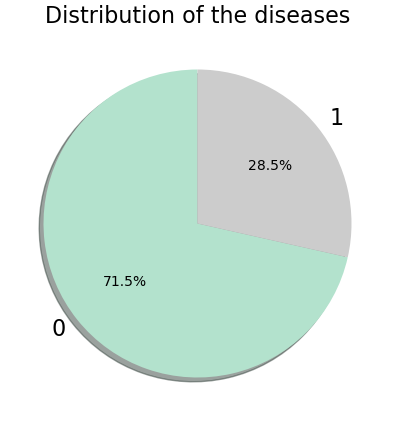

In [17]:
y_trainers.value_counts().plot(kind = "pie", figsize = (10, 5), cmap = 'Pastel2',
                                        title="Distribution of the diseases", ylabel = '',
                                        autopct='%1.1f%%', shadow=True, startangle=90);

In [18]:
# Creating tensforflow tensors with the training and testing dataset
def create_tensorflow_tensors(args:list):
    """Craete tensorflow tensors from *args
    Args:
        args(list): numpy arrays / pd.DataFrame
    Returns:
        tensfow tensors from *args"""
    outputs = []
    for arg in args:
        output = tf.constant(arg, dtype = tf.float32)
        outputs.append(output)
    return outputs

X_train, X_test, y_train, y_test = create_tensorflow_tensors([X_trainers, X_test, y_trainers, y_test])
print(f"dtype of X_train = {X_train.dtype}")
print(f"dtype of X_test = {X_test.dtype}")
print(f"dtype of y_train = {y_train.dtype}")
print(f"dtype of y_test = {y_test.dtype}")

dtype of X_train = <dtype: 'float32'>
dtype of X_test = <dtype: 'float32'>
dtype of y_train = <dtype: 'float32'>
dtype of y_test = <dtype: 'float32'>


## Building model with `TensorFlow`.

* Create the model using Multiple Perceptrons with increasing density and then decreasing density
* Compile the model using 
    * **Loss function** : `Binary Cross Entropy loss` as this is a **binary classification problem**
    * **Optimiser**: Choose `Adam` optimiser 
    * **Metrics** : `Accuracy` is looked during training. However, it may be changed to something else during model evaluation.
* Fit the model
    * **Epochs** : Start with 100 epochs and proceed from there
    * **Callbacks** : `Learning rate scheduler` will be used in the beginning to find optimal learning rate. Then, `accuracy callback` will be used with a `patience` of 30 epochs to stop overtraining and stagnation.


In [19]:
# Model creation
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(4, activation = "relu"), 
                    tf.keras.layers.Dense(8, activation = "relu"), 
                    tf.keras.layers.Dense(16, activation = "relu"),
#                     tf.keras.layers.Dense(32, activation = "relu"), 
#                     tf.keras.layers.Dense(64, activation = "relu"), 
#                     tf.keras.layers.Dense(32, activation = "relu"), 
#                     tf.keras.layers.Dense(64, activation = "relu"), 
#                     tf.keras.layers.Dense(128, activation = "relu"), 
                    tf.keras.layers.Dense(64, activation = "relu"), 
                    tf.keras.layers.Dense(16, activation = "relu"), 
                    tf.keras.layers.Dense(8, activation = "relu"), 
                    tf.keras.layers.Dense(1, activation = "sigmoid")])

"""Callbacks:
First we will be using the lr_scheduler callback to find the best learning rate.
Then, we will shift to accuracy_callback to prevent overfitting"""

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-4 * 10 ** (epoch / 20))
accuracy_callback = tf.keras.callbacks.EarlyStopping(monitor = "accuracy", patience = 100)

# Compile model
model.compile(optimizer = tf.keras.optimizers.Adam(), 
             loss = tf.keras.losses.BinaryCrossentropy(), 
             metrics = ["accuracy"])

# Fit the model
history = model.fit(X_train, y_train, epochs = 200, callbacks = [lr_scheduler], 
                    validation_data = (X_test, y_test), verbose = 0)

###  Determination of optimum learning rate from ***loss vs learning rate plot***

The optimum learning rate is found using the following algorithm:
* A plot is made between the loss and the learning rate used throughout the training.
* The minima of the plot is found corresponding to **minimum loss.**
* The optimum learning rate is usually 10% less than the learning rate corresponding to the minimum loss.
* The `xscale` of the plot is plotted in `log` scale to visualise better.

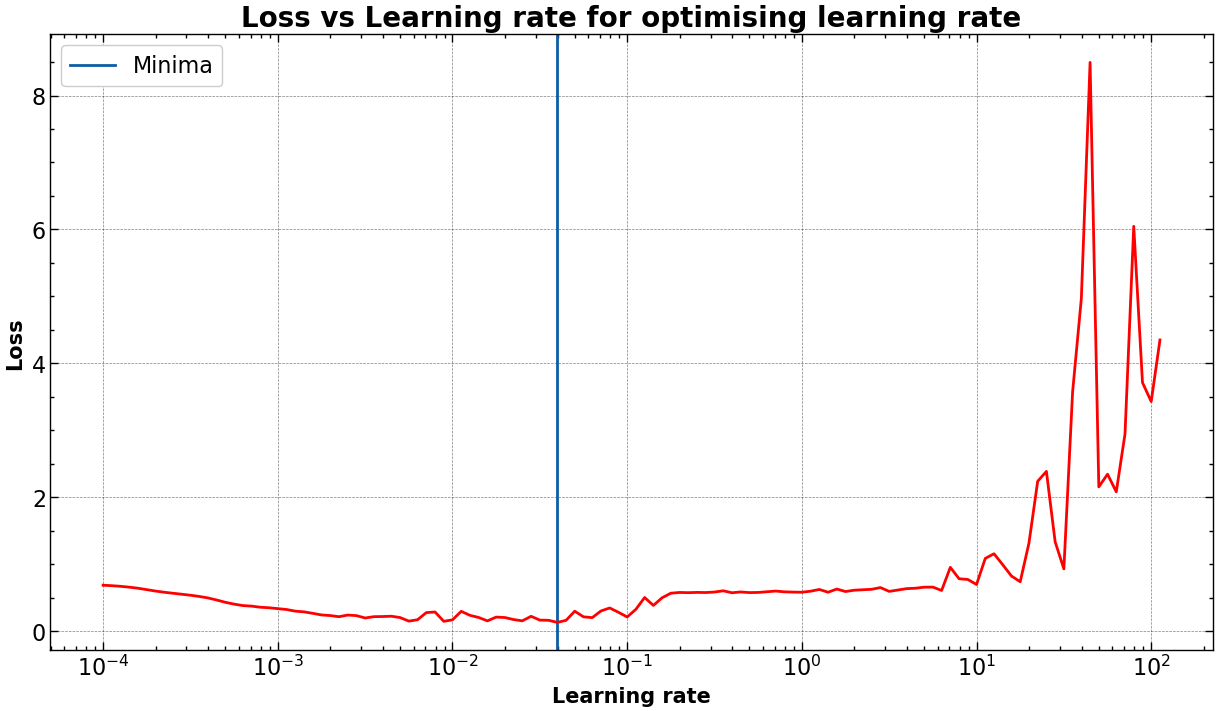

In [20]:
# Plot loss with history
hist = pd.DataFrame(history.history) # History object containing model performance history

plt.figure(figsize = (15, 8))
plt.xscale("log")
plt.xlabel("Learning rate", fontsize = 15, fontweight = "bold")
plt.ylabel("Loss", fontsize = 15, fontweight = "bold")
plt.title("Loss vs Learning rate for optimising learning rate", fontsize = 20, fontweight = "bold")
plt.axvline(hist['lr'][hist['loss'].argmin()], label = "Minima")
plt.plot(hist['lr'], hist['loss'], linewidth = 2, color = "red")
plt.legend()

🌝**NOTE**: The best learning rate seems to be at **$10^{-2}$** as can be seen from the plot

In [21]:
# Random seed
tf.keras.utils.set_random_seed(SEED)

# Hyperparameters
LEARNING_RATE = 1e-3
HIDDEN_ACTIVATION_FUNCTION : str = "relu"
OUTPUT_ACTIVATION_FUNCTION : str = "sigmoid" # output layer

# Build model
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(4, activation = "relu"), 
                    tf.keras.layers.Dense(8, activation = "relu"), 
                    tf.keras.layers.Dense(6, activation = "relu"), 
                    tf.keras.layers.Dense(1, activation = "sigmoid")])


# Model hyperparameters for compiling model
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FUNC = tf.keras.losses.BinaryCrossentropy() # Binary classification problem
METRICS = ["accuracy"]

# Compiling model
model.compile(optimizer = OPTIMIZER, loss = LOSS_FUNC, metrics = METRICS)

"""Callbacks:
First we will be using the lr_scheduler callback to find the best learning rate.
Then, we will shift to accuracy_callback to prevent overfitting"""

loss_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=80)

# Fit model
EPOCHS : int =  200
history = model.fit(X_train, y_train, epochs = EPOCHS, 
                    validation_data=(X_test, y_test), callbacks=[loss_callback], verbose = 2)

Epoch 1/200
18/18 - 2s - loss: 0.6753 - accuracy: 0.7148 - val_loss: 0.6514 - val_accuracy: 0.8306 - 2s/epoch - 105ms/step
Epoch 2/200
18/18 - 0s - loss: 0.6520 - accuracy: 0.7148 - val_loss: 0.6141 - val_accuracy: 0.8306 - 85ms/epoch - 5ms/step
Epoch 3/200
18/18 - 0s - loss: 0.6249 - accuracy: 0.7148 - val_loss: 0.5730 - val_accuracy: 0.8306 - 95ms/epoch - 5ms/step
Epoch 4/200
18/18 - 0s - loss: 0.5974 - accuracy: 0.7148 - val_loss: 0.5353 - val_accuracy: 0.8306 - 86ms/epoch - 5ms/step
Epoch 5/200
18/18 - 0s - loss: 0.5756 - accuracy: 0.7148 - val_loss: 0.5041 - val_accuracy: 0.8306 - 86ms/epoch - 5ms/step
Epoch 6/200
18/18 - 0s - loss: 0.5562 - accuracy: 0.7148 - val_loss: 0.4834 - val_accuracy: 0.8306 - 83ms/epoch - 5ms/step
Epoch 7/200
18/18 - 0s - loss: 0.5423 - accuracy: 0.7148 - val_loss: 0.4692 - val_accuracy: 0.8306 - 97ms/epoch - 5ms/step
Epoch 8/200
18/18 - 0s - loss: 0.5315 - accuracy: 0.7148 - val_loss: 0.4543 - val_accuracy: 0.8306 - 84ms/epoch - 5ms/step
Epoch 9/200
18/1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4)                 1204      
                                                                 
 dense_8 (Dense)             (None, 8)                 40        
                                                                 
 dense_9 (Dense)             (None, 6)                 54        
                                                                 
 dense_10 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,305
Trainable params: 1,305
Non-trainable params: 0
_________________________________________________________________


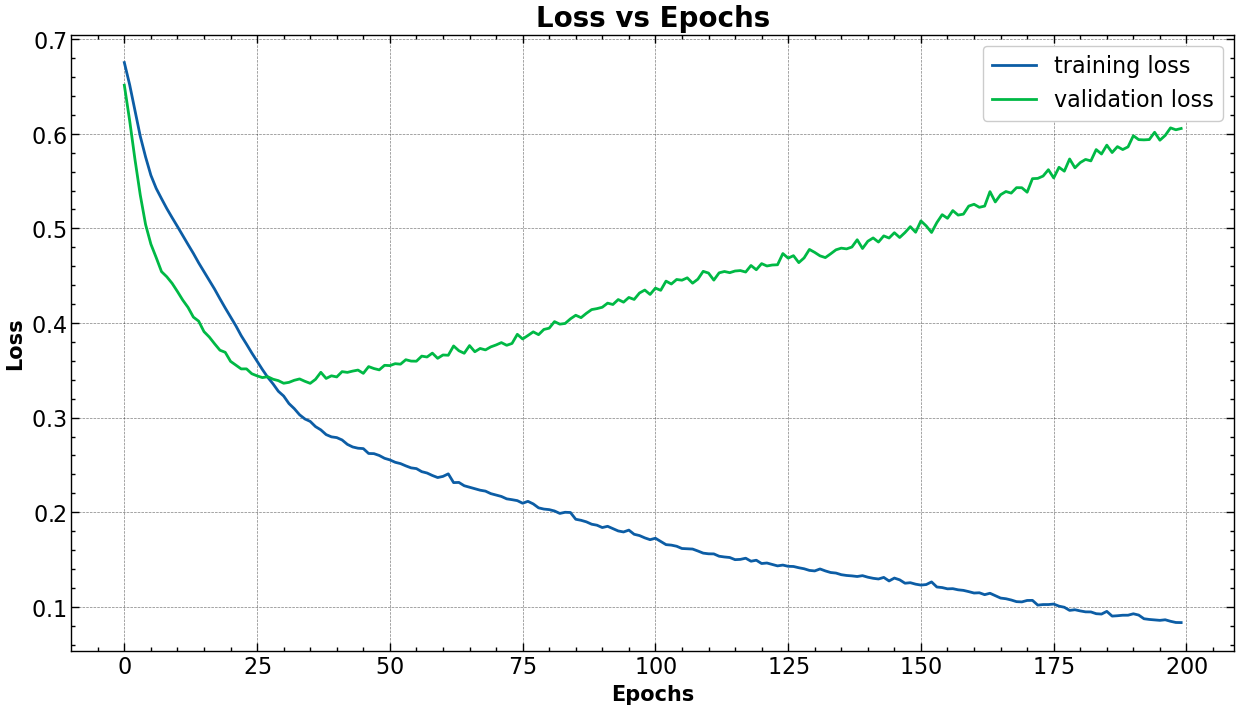

In [22]:
# Plot loss with history
hist = pd.DataFrame(history.history) # History object containing model performance history

plt.figure(figsize = (15, 8))
plt.xlabel("Epochs", fontsize = 15, fontweight = "bold")
plt.ylabel("Loss", fontsize = 15, fontweight = "bold")
plt.title("Loss vs Epochs", fontsize = 20, fontweight = "bold")
plt.plot(hist['loss'], label = "training loss")
plt.plot(hist['val_loss'], label = "validation loss")
plt.legend()

model.summary()

## Evaluation metrics
One of the underlying things to consider when dealing with imbalanced data in a classification
problem is which metric to use. Accuracy is commonly used as the de facto metric. However, for the
class imbalance problem, it’s not right to use accuracy as a metric. This problem is better known as
the accuracy paradox.
When using accuracy as the metric to evaluate a Machine Learning model that was trained with a
dataset with the class imbalance problem, the results can be misleading. 
In these cases, in addition to applying some method to fix the class imbalance problem, it is suggested to introduce other evaluation metrics such as **precision, recall and F1-Score.**


4/4 [==============================] - 0s 2ms/step
************************************************** Confusion Matrix **************************************************
[[12  9]
 [ 9 94]]

************************************************** Classification Report **************************************************
              precision    recall  f1-score   support

           1       0.57      0.57      0.57        21
           0       0.91      0.91      0.91       103

    accuracy                           0.85       124
   macro avg       0.74      0.74      0.74       124
weighted avg       0.85      0.85      0.85       124


************************************************** Accuracy score **************************************************
Accuracy score = 0.8548387096774194

************************************************** Area under the Curve **************************************************
ROC-AUC Score = 0.7702265372168284

*********************************************

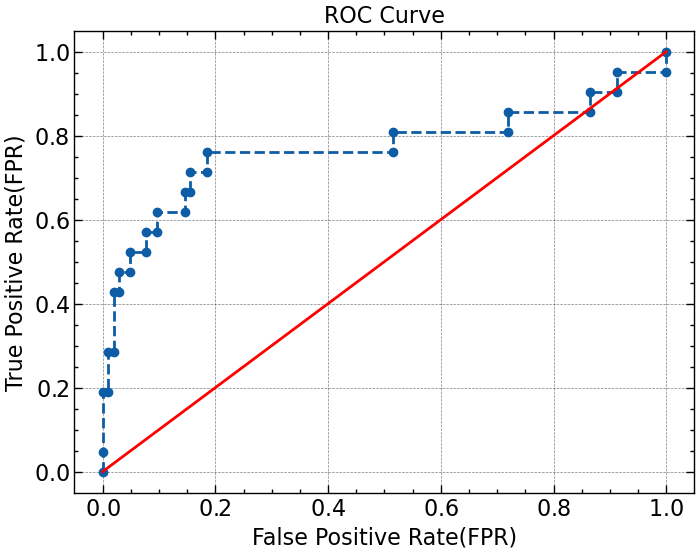

In [23]:
def get_metrics(model, X_test:np.ndarray, y_test:np.ndarray):
    """Gets various kinds of metrics for the model based on y_true
    Args:
        model: Model to evaluate
        X_test(np.ndarray): Testing features
        y_test(np.ndarray): original testing labels
    Returns:
        Model metrics and ROC plot"""
    
    probs = model.predict(X_test)
    y_pred = np.round(probs).ravel()
    y_true = y_test
    
    conf_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred, labels = [1, 0])
    class_report = classification_report(y_true = y_true, y_pred = y_pred, labels = [1, 0])
    accuracy = accuracy_score(y_true = y_true, y_pred = y_pred)
    
    print('*'*50, "Confusion Matrix", '*' * 50)
    print(conf_matrix, end = "\n\n")
    
    print('*'*50, "Classification Report", '*' * 50)
    print(class_report, end = "\n\n")
    
    print('*'*50, "Accuracy score", '*' * 50)
    print(f"Accuracy score = {accuracy}", end = "\n\n")
    
    # Values for getting ROC plot and AUC
    fpr, tpr, thresholds = roc_curve(y_true = y_true, y_score = probs)
    roc_score = roc_auc_score(y_true = y_true, y_score = probs)
    
    print('*'*50, "Area under the Curve", '*' * 50)
    print(f"ROC-AUC Score = {roc_score}", end = "\n\n")
    
    # Plot the roc curve
    plt.plot(fpr, tpr, 'o--')
    plt.xlabel("False Positive Rate(FPR)")
    plt.plot([0, 1], [0, 1], "r")
    plt.ylabel("True Positive Rate(FPR)")
    plt.title("ROC Curve")
    
    print('*'*50, "Threshold values of ROC Curve", '*' * 50)
    print(f"Threshold values = {thresholds}", end = "\n\n")
    
    
get_metrics(model, X_test, y_test)

Based on the ROC Curve, a **domain expert** can properly decide on the threshold value which would be prioritised for being as the threshold for the raw probabilities.

## Save Model for future use

The model was saved in `h5` format using `Tensorflow` functions so that it may be loaded later for future use.

In [24]:
# Save model
model.save("my_model.h5")

---
## Submissions
---

In [25]:
# Read the dataset
test_data = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
ids = test_data["Id"]

# Preprocess the dataset
test_data["BC_BZ"] = test_data["BC"] / test_data["BZ"]
test_data = preprocessor.fit_transform(test_data)
test_data = create_tensorflow_tensors([test_data])

#Predict results
probabilities = model.predict(test_data).ravel()
my_submission = pd.DataFrame({
    'Id' : ids,
    'cass_1' : probabilities,
    'class_0' : 1 - probabilities
})

# Save predictions
my_submission.to_csv("submission.csv", index = False)

# Show predictions
my_submission.head()

20/20 [==============================] - 0s 2ms/step


,Id,cass_1,class_0
0,000ff2bfdfe9,0.993340,0.006660
1,007255e47698,0.010278,0.989722
2,013f2bd269f5,0.298667,0.701333
3,043ac50845d5,0.000403,0.999597
4,044fb8a146ec,0.994960,0.005040
